# Effect of depthwise separable convolution 
This notebook elucidates the efficacy of depthwise separable convolutions (DSC) within the domain of neural segmentation tasks. Depthwise separable convolution represents a computational paradigm wherein the convolutional process is fragmented into two distinct stages: depthwise convolution and pointwise convolution. This method imposes a constraint on the potential kernels by necessitating a shared computational framework, specifically intermediate representations, across channels.

By deconstructing the convolutional operations, DSC significantly attenuates the computational complexity inherent in traditional convolutional neural networks (CNNs). This bifurcation not only enhances computational efficiency but also optimizes memory utilization, paramount for advanced neural network implementations and for deployment in environments with restricted computational capacity.

The critical inquiry this study addresses is whether DSCs facilitate the development of superior models compared to conventional CNNs when operating within identical computational resource constraints. This exploration is vital for understanding the trade-offs involved in model performance, resource allocation, and efficiency, particularly in the realm of image segmentation tasks where precision and resource management are pivotal. The overarching goal is to delineate the circumstances under which DSCs offer tangible advantages over their standard CNN counterparts, thereby guiding optimized neural network architecture configurations for image segmentation.

In [1]:
import sys
sys.path.append('../../Shared_Resources/Shared_Scripts')
sys.path.append('./utils')

#from utils_image_visualization import *
from utils_save_and_load_model import *
from utils_dataset_handling import *
from utils_segnet_model import *
from utils_segnet_metric import *
from utils_segmentation_training import *

## Download the data set

In [2]:
data_save_dir = '../../Shared_Resources/Shared_Data/'

In [3]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(data_save_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(data_save_dir, 'OxfordPets', 'test')

In [4]:
target_types = 'segmentation'
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", 
                                                target_types=target_types, download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", 
                                                target_types=target_types, download=True)

## Preprocess the data

In [5]:
image_size = 48

In [6]:
common_transform = T.Compose([
        ToDevice(get_device()),
        T.Resize((image_size,image_size), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ])

post_transform = T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ])

In [7]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=common_transform,
    post_transform=post_transform,
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [8]:
# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=12,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=6,
    shuffle=True,
)

In [9]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([12, 3, 48, 48]), torch.Size([12, 1, 48, 48]))

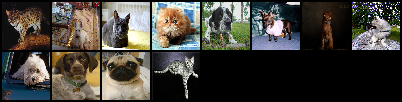

In [10]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

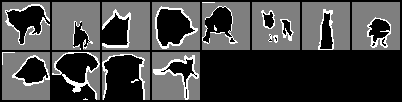

In [11]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

## Loss function (Custom IoU and Custom IoU Loss)
We define a custom IoU metric that is differentiable so that it can be used as a loss functions if needed.

This IoU metric is different from the standard IoU metric that has a hard distinction between predicted classes by the model. In this custom IoU metric, we use the probability of the predicted class (after applying SoftMax) to determine the degree of overlap. In that sense, this isn't a pure IoU metric, but it does help us capture the essense of an IoU metric.

IoU is also sometimes called Jaccard Index or Jaccard similarity metric.

### Why use IoU instead of pixel accuracy?
For segmentation tasks, if you have input images where (say) just 10% of the image has the object you wish to cover with the object segmentation mask, and the rest of the image is supposed to be classified as background, then the pixel accuracy metric may not be the best metric to use.

Here's why. If the model were to predict every pixel as a background pixel, it would trivially achieve 90% accuracy for its prediction!

Hence, for cases where the object and background pixels are unbalanced, an IoU metric may be a better choice.

Here are some links to learn more about metrics for segmentation tasks:

1. https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
2. https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388
3. https://towardsdatascience.com/evaluating-image-segmentation-models-1e9bb89a001b

In [12]:
def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z
# end def

test_custom_iou_loss()

tensor(1.6506, grad_fn=<NegBackward0>)

### Training functions

In [13]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path,print_every=2):
    os.makedirs(save_path, exist_ok=True)
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        if i%print_every==0:
            with torch.inference_mode():
                # Display the plt in the final training epoch.
                print_test_dataset_masks(model, test_inputs, test_targets, 
                                         epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step()

## SegNet Basic with standard convolutions

A SegNet model architecture, is well suited for image segmentation tasks, and isn't as memory intensive as U-Net models are. More information about the SegNet model and its architecture can be found here: https://arxiv.org/abs/1511.00561

### Define the model

In [14]:
#controlls the width of the convolutions, which is 2**(width_complexity+depth). The larger the more parameters.
width_complexity=3

In [15]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
m = SegNet(kernel_size=3, width_complexity = width_complexity)
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

torch.Size([12, 3, 48, 48])

In [16]:
print_model_parameters(m)

The Model has 0.24M parameters


### Train the model

In [17]:
n_epochs=5

In [18]:
working_dir = '../meta_data/segnet/'#where to store figures
model_save_path = '../models/segnet/'#where we store models

In [19]:
# Optimizer and Learning Rate Scheduler.
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.9920
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8431
Epoch: 02, Accuracy[Pixel: 0.6908, IoU: 0.4579, Custom IoU: 0.3631]
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7600
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7240
Epoch: 04, Accuracy[Pixel: 0.7329, IoU: 0.5003, Custom IoU: 0.4274]


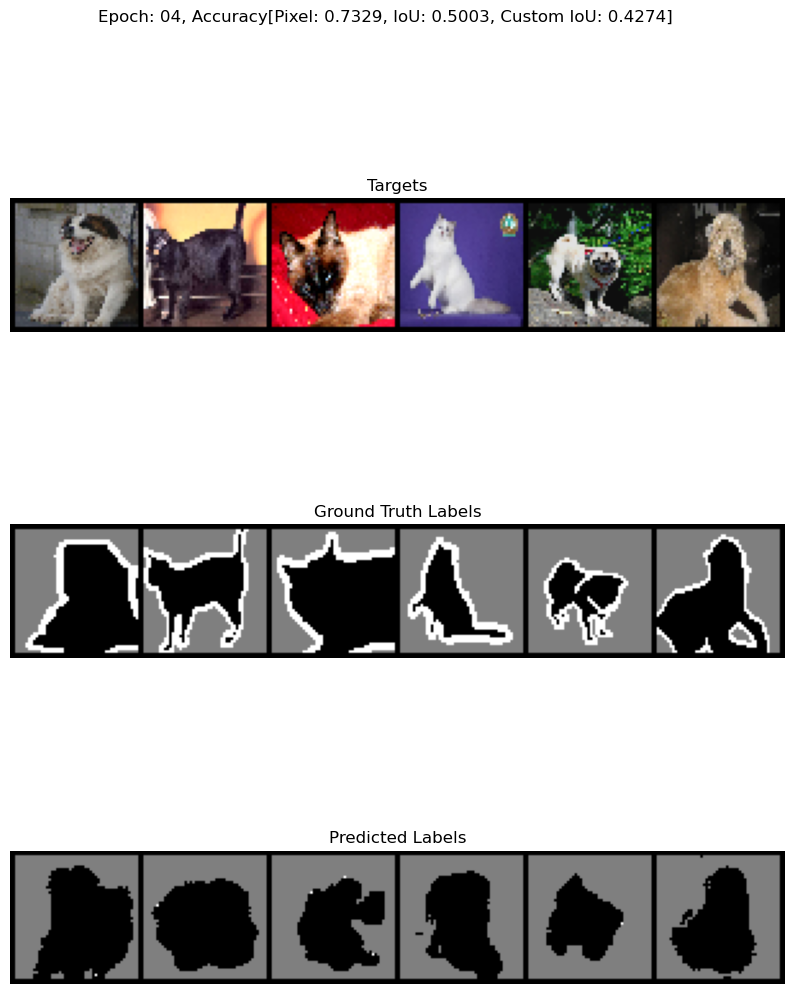

In [20]:
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, n_epochs), 
                           optimizer, scheduler, save_path)

In [21]:
# Save the model's checkpoint.
os.makedirs(model_save_path, exist_ok=True)
save_model_checkpoint(m,model_save_path,f"pets_segnet_CrossEntropyLoss_LRSchedule_"+str(n_epochs)+"_epochs.pth")

## SegNet Basic with depthwise-separable convolutions
We use depthwise separable convolutions to reduce the model's size (number of trainable parameters).

Depthwise Separable convolutions were first introduced by L. Sifre. Rigid-motion scattering for image classiﬁcation, 2014. in their Ph.D. thesis.

Depthwise separable convolutions were made popular by Mobilenet. You can read more about them here: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

### Define the model

In [22]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
mdsc = SegNetDSC(kernel_size=3,width_complexity = width_complexity)
mdsc.eval()
to_device(mdsc)
mdsc(to_device(train_pets_inputs)).shape

torch.Size([12, 3, 48, 48])

In [23]:
print_model_parameters(mdsc)

The Model has 0.03M parameters


### Train the model

In [24]:
to_device(mdsc)
optimizer2 = torch.optim.Adam(mdsc.parameters(), lr=0.001)
scheduler2 = None

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 1.0480
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8549
Epoch: 02, Accuracy[Pixel: 0.6868, IoU: 0.4315, Custom IoU: 0.3527]
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7540
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7223
Epoch: 04, Accuracy[Pixel: 0.7083, IoU: 0.4470, Custom IoU: 0.4163]


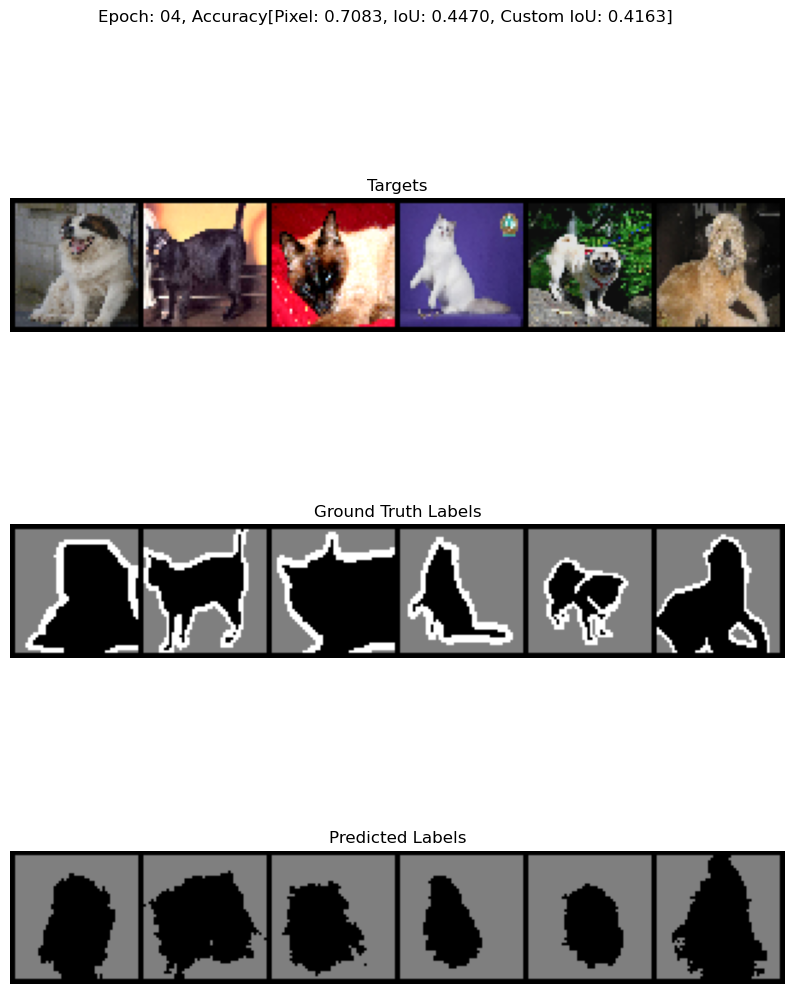

In [25]:
# Train the model that uses depthwise separable convolutions.
save_path2 = os.path.join(working_dir, "segnet_basic_dsc_training_progress_images")
train_loop(mdsc, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, n_epochs), 
           optimizer2, scheduler2, save_path2)

In [26]:
save_model_checkpoint(mdsc,model_save_path, f"pets_segnet_DSC_CrossEntropyLoss_"+str(n_epochs)+"_epochs.pth")

## Validate model accuracy on the complete test dataset
So far, we have been checking the metrics of interest only on a small subset of the test dataset (21 images).

Now, let's try to compute these numbers on the entire test dataset so that we can be sure that the numbers are representative.

In [27]:
# Load both model checkpoints.

#---- optionally reinitializing models (we could also use the existing once and overwrite the weights)
#mdsc = SegNetDSC(kernel_size=3,width_complexity = width_complexity)
#m = SegNet(kernel_size=3, width_complexity = width_complexity)

#loading the weights from the check-point
load_model_from_checkpoint(m, model_save_path+"/pets_segnet_CrossEntropyLoss_LRSchedule_"+str(n_epochs)+"_epochs.pth")
load_model_from_checkpoint(mdsc, model_save_path+"/pets_segnet_DSC_CrossEntropyLoss_"+str(n_epochs)+"_epochs.pth")

<All keys matched successfully>

In [28]:
# Let's test the accuracy of both models on the test dataset.
with torch.inference_mode():
    test_dataset_accuracy(m, pets_test_loader)
    test_dataset_accuracy(mdsc, pets_test_loader)

The Model has 0.24M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.7235, IoU Accuracy: 0.4356, Custom IoU Accuracy: 0.4275
The Model has 0.03M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.7178, IoU Accuracy: 0.4421, Custom IoU Accuracy: 0.4215


In [29]:
# Clear the PyTorch CUDA cache to free up some memory.
torch.cuda.empty_cache()

### Compare model speed and memory consumption at inference time

In [30]:
import time
import psutil
from torch.cuda.amp import autocast

In [38]:
def inference_only(model, loader,n_batches = 1e8,with_torch_compile=False,low_precision=False,
                  quantization=False):
    
    print_model_parameters(model)
    
    if quantization:
        # Specify the quantization configuration
        model.qconfig = torch.quantization.get_default_qconfig('fbgemm')  # 'fbgemm' for x86 CPUs, 'qnnpack' for ARM
        # Convert the model to a quantized version
        # By not specifying any layer types, it quantizes all supported layers
        model = torch.quantization.quantize_dynamic(
            model,
            dtype=torch.qint8
        )  
            
            
            
    if with_torch_compile:
        model = torch.compile(model, mode="reduce-overhead")
    
    dt=0
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        start_memory = torch.cuda.memory_allocated()
        
    else:
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss
    
    to_device(model.eval())
    
    if with_torch_compile:
        #warm-up
        print('-warm-up-')
        for batch_idx, (inputs, targets) in enumerate(loader, 0):
            inputs = to_device(inputs)
            with torch.no_grad():
                predictions = model(inputs)
            break

    print('start test...')
    #start test
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        if batch_idx%25==0:
            print('batch_idx: ',batch_idx)
            
        inputs = to_device(inputs)
        
        t = time.time()
        with torch.no_grad():
            if low_precision:
                with autocast():#works only for GPU
                    predictions = model(inputs)
            else:
                predictions = model(inputs)
        dt+=time.time()-t
        
        if batch_idx>n_batches:
            break
        
    if torch.cuda.is_available():
        end_memory = torch.cuda.memory_allocated()
    else:
        end_memory = process.memory_info().rss
        
    memory_used = end_memory - start_memory
        
    print(f"Memory used for inference: {format(memory_used, '.2e')} bytes")
        
    
    print('Ellapsed time: ',dt)
    
    return dt


In [57]:
mdsc = SegNetDSC(kernel_size=3,width_complexity = 6)
m = SegNet(kernel_size=3, width_complexity = 6)

print_model_parameters(mdsc)
print_model_parameters(m)

The Model has 1.75M parameters
The Model has 15.27M parameters


In [58]:
inference_only(mdsc, pets_test_loader,n_batches=100,with_torch_compile=False,low_precision=False,
                          quantization=False)
inference_only(m, pets_test_loader,n_batches=100,with_torch_compile=False,low_precision=False,
                          quantization=False)

The Model has 1.75M parameters
start test...
batch_idx:  0
batch_idx:  25
batch_idx:  50
batch_idx:  75
batch_idx:  100
Memory used for inference: 7.50e+06 bytes
Ellapsed time:  0.36609840393066406
The Model has 15.27M parameters
start test...
batch_idx:  0
batch_idx:  25
batch_idx:  50
batch_idx:  75
batch_idx:  100
Memory used for inference: 6.25e+07 bytes
Ellapsed time:  0.46111464500427246


0.46111464500427246

In [40]:
time_mdsc = inference_only(mdsc, pets_test_loader,n_batches=100,with_torch_compile=False,low_precision=False,
                          quantization=True)

The Model has 1.75M parameters
start test...
batch_idx:  0
batch_idx:  25
batch_idx:  50
batch_idx:  75
batch_idx:  100
Memory used for inference: 7.50e+06 bytes
Ellapsed time:  0.3630869388580322


In [41]:
time_mdsc = inference_only(mdsc, pets_test_loader,n_batches=100,with_torch_compile=False,low_precision=False,
                          quantization=False)

The Model has 1.75M parameters
start test...
batch_idx:  0
batch_idx:  25
batch_idx:  50
batch_idx:  75
batch_idx:  100
Memory used for inference: 7.50e+06 bytes
Ellapsed time:  0.36358118057250977


In [42]:
time_m = inference_only(m, pets_test_loader,n_batches=100,with_torch_compile=True,low_precision=False,
                          quantization=False)

The Model has 3.82M parameters


RuntimeError: Windows not yet supported for torch.compile

### Testing the single convolution layers: DWS against fully connected

In [54]:
# Define the input dimensions
input_tensor = torch.rand(1, 32, 224, 224)  # Example input (batch_size, channels, height, width)

# Full Convolution
class FullConv(nn.Module):
    def __init__(self,in_ch=32,out_ch=64,kernel_size=3,padding=1):
        super(FullConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding)

    def forward(self, x):
        return self.conv(x)

# Depthwise Separable Convolution
class DepthwiseSeparableConv(nn.Module):
    def __init__(self,in_ch=32,out_ch=64,kernel_size=3,padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=32)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        return self.pointwise(x)

# Initialize the models
full_conv = nn.Conv2d(32,64, kernel_size=3, padding=1)
#full_conv = FullConv(32,64, kernel_size=3, padding=1)
depthwise_sep_conv = DepthwiseSeparableConv2d(32,64, kernel_size=3, padding=1)
#depthwise_sep_conv = DepthwiseSeparableConv(32,64, kernel_size=3, padding=1)

# Measure time for full convolution
start_time = time.time()
with torch.no_grad():
    output_full_conv = full_conv(input_tensor)
full_conv_time = time.time() - start_time

# Measure time for depthwise separable convolution
start_time = time.time()
with torch.no_grad():
    output_depthwise_sep_conv = depthwise_sep_conv(input_tensor)
depthwise_sep_conv_time = time.time() - start_time

print("Full Convolution Time: {:.6f} seconds".format(full_conv_time))
print("Depthwise Separable Convolution Time: {:.6f} seconds".format(depthwise_sep_conv_time))


Full Convolution Time: 0.008001 seconds
Depthwise Separable Convolution Time: 0.005002 seconds
